## Метод Гаусса с выбором главного эл-та по столбцу

In [1]:
import numpy as np
from typing import Tuple


def swap_slices(arr: np.ndarray,
                first_slice: Tuple[slice],
                second_slice: Tuple[slice]) -> None:
    temp = arr[first_slice].copy()
    arr[first_slice] = arr[second_slice]
    arr[second_slice] = temp
    

def lu_decomposition(mat: np.ndarray) -> Tuple[np.ndarray]:
    '''
    mat = p_mat @ l_mat @ u_mat
    '''
    n = len(mat)
    u_mat = mat.copy().astype('float')
    l_mat = np.eye(n)
    p_mat = np.eye(n)
    
    for k in range(n-1):
        i = k + np.argmax(np.abs(u_mat[k:, k]))
        
        if k != i:
            swap_slices(
                u_mat,
                (slice(k, k+1), slice(k, n)),
                (slice(i, i+1), slice(k, n))
            )
            swap_slices(
                l_mat,
                (slice(k, k+1), slice(k)),
                (slice(i, i+1), slice(k))
            )
            swap_slices(
                p_mat,
                (slice(k, k+1), slice(n)),
                (slice(i, i+1), slice(n))
            )
        
        for j in range(k+1, n):
            l_mat[j, k] = u_mat[j, k] / u_mat[k, k]
            u_mat[j, k:] = u_mat[j, k:] - l_mat[j, k] * u_mat[k, k:]
            
    p_mat = p_mat.T
            
    return p_mat, l_mat, u_mat


def direct_substitution(l_mat: np.ndarray, vec: np.ndarray) -> np.ndarray:
    '''
    Solve an equation: l_mat @ y = vec, where l_mat is a lower-triangle matrix
    '''
    n = vec.size
    sol = np.zeros(n)
    
    for k in range(n):
        sol[k] = (vec[k] - np.dot(sol[:k], l_mat[k, :k])) / l_mat[k, k]
    
    return sol


def reverse_substitution(u_mat: np.ndarray, vec: np.ndarray) -> np.ndarray:
    '''
    Solve an equation: u_mat @ y = vec, where u_mat is an upper-triangle matrix
    '''
    n = vec.size
    sol = np.zeros(n)
    
    for k in reversed(range(n)):
        sol[k] = (vec[k] - np.dot(sol[k+1:], u_mat[k, k+1:])) / u_mat[k, k]
    
    return sol


def gauss_method(mat: np.ndarray, vec: np.ndarray) -> Tuple[np.ndarray]:
    '''
    Solve an equation: mat @ x = vec
    '''
    if mat.ndim != 2 or mat.shape[0] != mat.shape[1]:
        raise ValueError(f'mat shape should be like (n, n), got {mat.shape}')
        
    if vec.ndim != 1 or mat.shape[0] != vec.size:
        raise ValueError('vec should be a 1D-array and len(mat) == len(vec),'
                         f'but {len(mat)} != {len(vec)}')
    
    p_mat, l_mat, u_mat = lu_decomposition(mat)
    vec = p_mat.T @ vec
    temp_sol = direct_substitution(l_mat, vec)
    sol = reverse_substitution(u_mat, temp_sol)
    
    return p_mat, l_mat, u_mat, sol

**Тесты**

In [11]:
from scipy.linalg import lu


np.random.seed(2023)
n = 100
atol = 1e-8

for _ in range(10):
    mat = np.random.rand(n, n)
    vec = np.random.rand(n)
    p2, l2, u2, sol = gauss_method(mat, vec)
    
    assert(np.linalg.norm(mat - p2 @ l2 @ u2) < atol)
    assert(np.linalg.norm(mat @ sol - vec) < atol)
    # print(np.linalg.norm(mat @ sol - vec))
else:
    print('All tests are passed!')

7.978889485702216e-14
1.715573004442836e-14
2.6595345629335027e-14
1.8535072814093574e-14
3.853145729765326e-14
1.9856199900665218e-14
1.698571071969517e-14
2.0723138788111524e-14
6.515763107970786e-14
2.168461964780437e-14
All tests are passed!


## Метод наискорейшего спуска и метод минимальных невязок

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from typing import Tuple


def decorator_timer(some_function):
    from time import time

    def wrapper(*args, **kwargs):
        t1 = time()
        result = some_function(*args, **kwargs)
        end = time() - t1
        return result, end
    
    return wrapper


def steepest_descent_method(
        mat: np.ndarray,
        vec: np.ndarray,
        n_iter: int,
        tol: float) -> np.ndarray:
    sol = np.zeros(vec.size)
    residuals = []
    
    for _ in range(n_iter):
        resid = mat @ sol - vec
        residuals.append(np.linalg.norm(resid))
        
        tau = np.dot(resid, resid)
        tau /= np.dot(mat @ resid, resid)
        
        sol -= tau * resid
        
        if np.linalg.norm(mat @ sol - vec) < tol:
            break
            
    return sol, residuals


def residuals_method(
        mat: np.ndarray,
        vec: np.ndarray,
        n_iter: int,
        tol: float) -> np.ndarray:
    
    sol = np.zeros(vec.size)
    resid = np.zeros(vec.size)
    residuals = []
    
    residual_func = lambda tau: np.linalg.norm(mat @ (sol - tau*resid) - vec)
    
    for _ in range(n_iter):
        resid = mat @ sol - vec
        residuals.append(np.linalg.norm(resid))
        
        tau = minimize_scalar(residual_func, bounds=(0, 0.01)).x
        sol -= tau*resid
        
        if np.linalg.norm(mat @ sol - vec) < tol:
            break
            
    return sol, residuals


@decorator_timer
def final_func(
        mat: np.ndarray,
        vec: np.ndarray,
        n_iter: int,
        tol: float,
        method: str = 'descent') -> np.ndarray:
    assert method in ('resid', 'descent')
    
    if mat.ndim != 2 or mat.shape[0] != mat.shape[1]:
        raise ValueError(f'mat shape should be like (n, n), got {mat.shape}')
        
    if vec.ndim != 1 or mat.shape[0] != vec.size:
        raise ValueError('vec should be a 1D-array and len(mat) == len(vec),'
                         f'but {len(mat)} != {len(vec)}')
    
    sol, residuals = None, None
    
    if method == 'descent':
        sol, residuals = steepest_descent_method(mat, vec, n_iter, tol)
    elif method == 'resid':
        sol, residuals = residuals_method(mat, vec, n_iter, tol)
        
    return sol, residuals


@decorator_timer
def find_exact_sol(mat: np.ndarray, vec: np.ndarray):
    if mat.ndim != 2 or mat.shape[0] != mat.shape[1]:
        raise ValueError(f'mat shape should be like (n, n), got {mat.shape}')
        
    if vec.ndim != 1 or mat.shape[0] != vec.size:
        raise ValueError('vec should be a 1D-array and len(mat) == len(vec),'
                         f'but {len(mat)} != {len(vec)}')

    return np.linalg.solve(mat, vec)


def generate_data(n: int) -> Tuple[int]:
    temp_mat = np.random.rand(n, n)
    mat = temp_mat.T @ temp_mat + np.eye(n)
    vec = np.random.rand(n)
    
    return mat, vec


def full_pipeline(n: int, seed: int, method: str, n_iter: int = 200, tol: float = 1e-6) -> None:
    np.random.seed(seed)
    
    mat, vec = generate_data(n)
    print(np.linalg.cond(mat))
    (sol, residuals), my_time = final_func(mat, vec, n_iter, tol, method)
    exact_sol, exact_time = find_exact_sol(mat, vec)
    
    print(f'Число итераций: {len(residuals)}')
    print(f'Время итеративного решения: {round(my_time, 3)} секунд')
    print(f'Время точного решения: {round(exact_time, 3)} секунд')
    print(f'2-норма погрешности решения: {np.linalg.norm(sol - exact_sol)}')
    
    plt.figure(figsize=(12, 7))
    plt.plot(np.abs(residuals))
    plt.yscale('log')
    plt.xlabel('Номер итерации')
    plt.ylabel('Невязка')
    plt.grid(True)
    plt.show()
    
    return sol, exact_sol

10040.952166508623
Число итераций: 500
Время итеративного решения: 2.419 секунд
Время точного решения: 0.004 секунд
2-норма погрешности решения: 0.024291521169005893


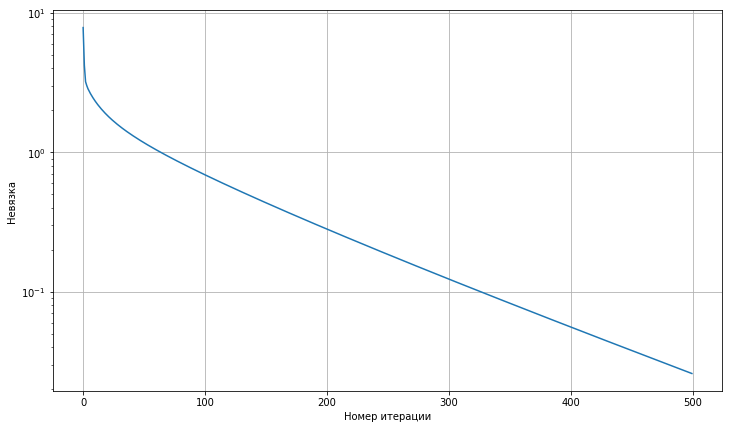

In [14]:
sol, exact_sol = full_pipeline(200, 3333, 'resid', 500)

10040.952166508623
Число итераций: 2000
Время итеративного решения: 0.108 секунд
Время точного решения: 0.001 секунд
2-норма погрешности решения: 0.7357154657099112


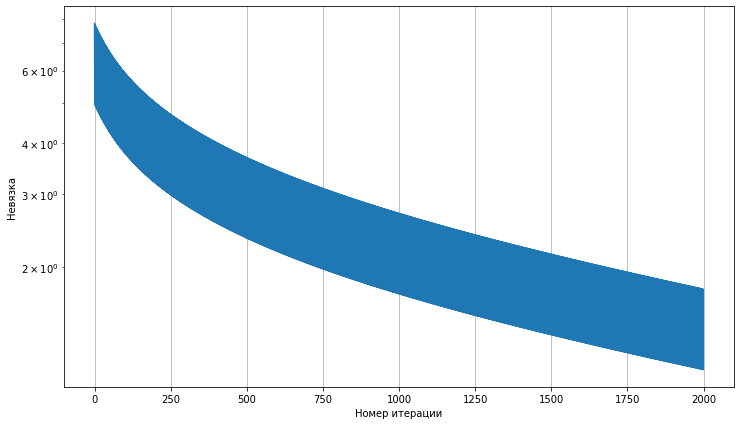

In [16]:
sol, exact_sol = full_pipeline(200, 3333, 'descent', 2000)